In [4]:
import sys
sys.path.append('../')

import numpy as np
np.random.seed(314159)

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import parameter_tuning
import plot_boundary
import analysis_functions as af

from metric_functions import compute_accuracy, compute_auc_from_scores
from kernel_SVM_functions import rbf_kernel
from classifiers import QUBOSoftMarginClassifier, SoftMarginKernelClassifier

In [ ]:
train_size = 0.7
filename = 'versicolor-virginica'

run_qsvms = False
run_csvm = False

In [5]:
data = pd.read_csv(f'../iris_data/{filename}.csv').to_numpy()

X = data[:, 1: -1]
t = data[:, -1]
#iris_setosa will be 1, iris-versicolor will be -1
t[t == 'Iris-versicolor'] = 1
t[t == 'Iris-virginica'] = -1
t = t.astype('float')

X_train, X_test, t_train, t_test = train_test_split(X, t, train_size = train_size, shuffle = True, stratify = t)
t_train = t_train.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)

## QSVMs Calibration

In [30]:
B_values = [2, 3, 5, 10]
K_values = [2, 3, 4]
R_values = [0, 1, 3, 5]
gamma_values = [2 ** i for i in range(-3, 3)]
kernel_func = rbf_kernel
#This results in a matrix with shape (4, 2, 4, 7)

if run_qsvms:

    accuracy_results, auroc_results, times = parameter_tuning.tune_qsvm_parameters(X_train, t_train, B_values, K_values, R_values, gamma_values, kernel_func, num_models = 30)

    np.save(f'../results/QUBO-{filename}-accuracy', accuracy_results)
    np.save(f'../results/QUBO-{filename}-auroc', auroc_results)
    np.save(f'../results/QUBO-{filename}-time', times)

## cSVM Calibration

In [7]:
C_values = [2 ** i for i in range(0, 7)]
gamma_values = [2 **i for i in range(-3, 3)]
kernel_func = rbf_kernel

if run_csvm:

    accuracy_results, auroc_results, times = parameter_tuning.tune_csvm_parameters(X_train, t_train, C_values, gamma_values, kernel_func)

    np.save(f'../results/kSVM-{filename}-accuracy', accuracy_results)
    np.save(f'../results/kSVM-{filename}-auroc', auroc_results)
    np.save(f'../results/kSVM-{filename}-time', times)

## Get data from files

In [8]:
qSVM_accuracy = np.load(f'../results/QUBO-{filename}-accuracy.npy')
qSVM_auroc = np.load(f'../results/QUBO-{filename}-auroc.npy')

cSVM_accuracy = np.load(f'../results/kSVM-{filename}-accuracy.npy')
cSVM_auroc = np.load(f'../results/kSVM-{filename}-auroc.npy')

In [9]:
print(qSVM_accuracy.shape, cSVM_accuracy.shape)

(4, 3, 4, 6) (7, 6)


## Best Calibration performance

In [10]:
print(f'cSVM best accuracy {np.max(cSVM_accuracy[:, 1: ])} \n cSVM best auroc {np.max(cSVM_auroc[:, 1: ])} \n')
print(f'qSVM best accuracy {np.max(qSVM_accuracy)} \n qSVM best auroc {np.max(qSVM_auroc)} \n')

cSVM best accuracy 1.0 
 cSVM best auroc 1.0 

qSVM best accuracy 0.8266666666666668 
 qSVM best auroc 0.9566666666666667 



## Best QSVMs models

In [11]:
#Finding the top 20 QSVMs models based on calibration AUROC score.

val_list = [B_values, K_values, R_values, gamma_values]
model_indices = af.find_best(qSVM_auroc, 20)
top_qsvms_models = [af.get_params(val_list, model_indices[i]) for i in range(len(model_indices))]

In [12]:
#50 of each of the top models are trained on the full training set and tested on the test set.
#The AUROC and accuracy is averaged as the final AUROC and Accuracy score for that dataset.

tp_acc_mean = []
tp_acc_std = []

tp_auc_mean = []
tp_auc_std = []

kernel_func = rbf_kernel
n = 50

#Averaging the accuracy and auc for each parameter set over 50 models
for i, model_parameters in enumerate(top_qsvms_models):

    accuracy = []
    auroc = []

    for j in range(n):
        
        qsmc = QUBOSoftMarginClassifier(model_parameters[0], model_parameters[1], model_parameters[2], kernel_func, model_parameters[3])
        qsmc = qsmc.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
        scores = qsmc.decision_function(X_test)
        preds = qsmc.predict(X_test)
        
        accuracy.append(compute_accuracy(preds, t_test))
        auroc.append(compute_auc_from_scores(scores, t_test))

    tp_acc_mean.append(np.mean(accuracy))
    tp_acc_std.append(np.std(accuracy))

    tp_auc_mean.append(np.mean(auroc))
    tp_auc_std.append(np.std(auroc))

In [13]:
sort_index = np.unravel_index(np.argsort(-np.array(tp_auc_mean)), np.array(tp_auc_mean).shape)

top_qsvms_models = np.array(top_qsvms_models)[sort_index]

tp_acc_mean = np.array(tp_acc_mean)[sort_index]
tp_acc_std = np.array(tp_acc_std)[sort_index]

tp_auc_mean = np.array(tp_auc_mean)[sort_index]
tp_auc_std = np.array(tp_auc_std)[sort_index]

array([[2.   , 4.   , 0.   , 0.25 ],
       [2.   , 4.   , 0.   , 0.5  ],
       [5.   , 4.   , 0.   , 0.125],
       [3.   , 4.   , 0.   , 0.25 ],
       [2.   , 3.   , 0.   , 0.5  ],
       [3.   , 3.   , 0.   , 1.   ],
       [3.   , 4.   , 0.   , 0.5  ],
       [2.   , 3.   , 5.   , 1.   ],
       [2.   , 3.   , 1.   , 0.125],
       [5.   , 3.   , 0.   , 0.125],
       [5.   , 4.   , 0.   , 0.5  ],
       [2.   , 3.   , 1.   , 0.5  ],
       [2.   , 2.   , 0.   , 1.   ],
       [2.   , 2.   , 1.   , 0.5  ],
       [2.   , 4.   , 3.   , 0.5  ],
       [2.   , 2.   , 3.   , 1.   ],
       [2.   , 4.   , 1.   , 0.25 ],
       [3.   , 4.   , 3.   , 0.125],
       [3.   , 2.   , 5.   , 0.5  ],
       [5.   , 4.   , 1.   , 0.125]])

In [ ]:
print(top_qsvms_models)

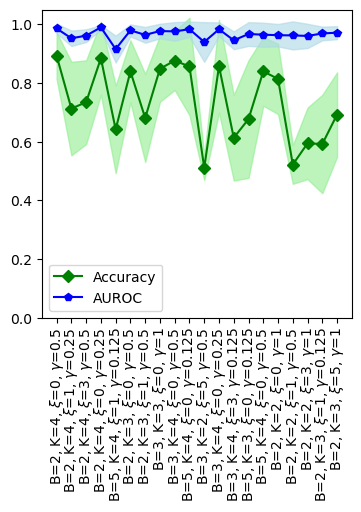

In [14]:
fig, ax = plt.subplots(figsize = (4, 4))

af.plot_top_models(top_qsvms_models, np.array([tp_acc_mean, tp_acc_std]), np.array([tp_auc_mean, tp_auc_std]), fig = fig, ax = ax)
plt.savefig('../plots/virgi-versi_qsvms_plot.png', dpi = 256)
plt.show()

## Best cSVM models

In [17]:
C_values

[1, 2, 4, 8, 16, 32, 64]

In [18]:
clf = SoftMarginKernelClassifier(32, kernel_func, 2)
clf = clf.fit(X_train, t_train)

scores = clf.decision_function(X_test)
preds = clf.predict(X_test)

auc = compute_auc_from_scores(scores, t_test)
acc = compute_accuracy(preds, t_test)
print(auc, acc)

0.9368749999999999 0.9125


## cSVM boundary plot

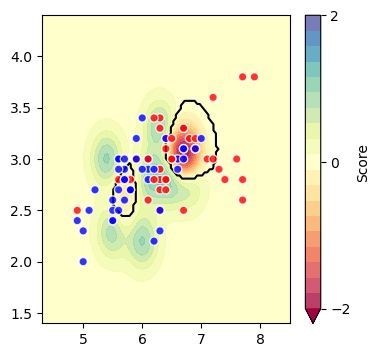

In [19]:
#Showing the decision boundary between petal length and petal width -- which divides the data really well. 
dimensions = [0, 1]
clf = SoftMarginKernelClassifier(1, kernel_func, 16)
clf = clf.fit(X_train, t_train)
scores = clf.decision_function(X_test)
preds = clf.predict(X_test)
c_prob_dist = clf.predict_proba(X_test)

clf.support_vectors = clf.support_vectors[:, dimensions]
clf.alphas = clf.alphas[dimensions]
plot_X_test = X_test[:, dimensions]
plot_t_test = t_test

plot_boundary.plot(plot_X_test, plot_t_test, clf, contour_func = 'decision_function', colorbar = True)

## qSVM boundary plot

/Users/isaaccopson/Desktop/Research Project/ResearchProjectRepo/Main/DataAnalysis/../plot_boundary.py:52: UserWarning: No contour levels were found within the data range.
  cs = ax.contour(xx, yy, prediction, [0], cmap = 'bone')


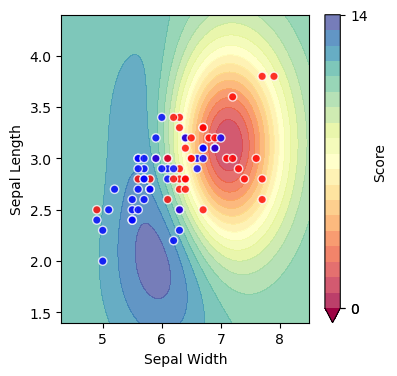

In [20]:
#Showing the decision boundary between petal length and petal width -- which divides the data really well. 
clf = QUBOSoftMarginClassifier(2, 3, 5, kernel_func, 1)
clf = clf.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
scores = clf.decision_function(X_test)
preds = clf.predict(X_test)
q_prob_dist = clf.predict_proba(X_test)

clf.support_vectors = clf.support_vectors[:, dimensions]
clf.alphas = clf.alphas[dimensions]

fig, ax = plt.subplots(figsize = (4, 4))

plot_boundary.plot(plot_X_test, plot_t_test, clf, contour_func = 'decision_function', colorbar = True, fig = fig, ax = ax)
ax.set_ylabel('Sepal Length')
ax.set_xlabel('Sepal Width')
plt.show()

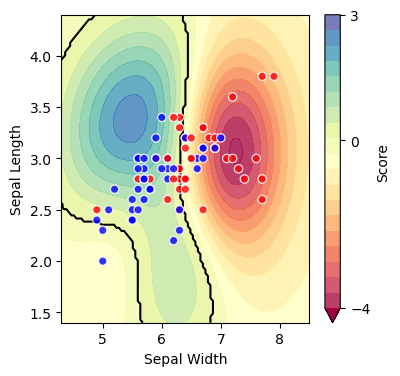

In [21]:
#Showing the decision boundary between petal length and petal width -- which divides the data really well. 
dimensions = [0, 1]
clf = QUBOSoftMarginClassifier(5, 3, 0, kernel_func, 1)
clf = clf.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
scores = clf.decision_function(X_test)
preds = clf.predict(X_test)
q_prob_dist = clf.predict_proba(X_test)

clf.support_vectors = clf.support_vectors[:, dimensions]
clf.alphas = clf.alphas[dimensions]

fig, ax = plt.subplots(figsize = (4, 4))

plot_boundary.plot(plot_X_test, plot_t_test, clf, contour_func = 'decision_function', colorbar = True, fig = fig, ax = ax)
ax.set_ylabel('Sepal Length')
ax.set_xlabel('Sepal Width')
plt.show()

### Probability distribution of the models

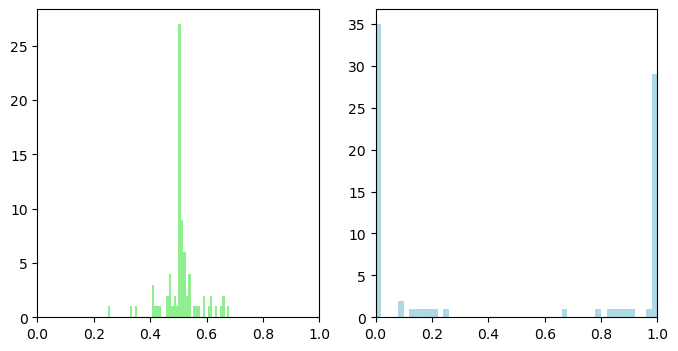

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

ax[0].hist(c_prob_dist, label = 'cSVM probability distribution', color = 'lightgreen', bins = 50)
ax[1].hist(q_prob_dist, label = 'qSVM probability distribution', color = 'lightblue', bins = 50)

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)

plt.show()

In [23]:
qSVM_accuracy.shape, cSVM_accuracy.shape

((4, 3, 4, 6), (7, 6))

## Variance

4 different values of R. For each other combination of the other 3 hyper-parameters -- B, K, gamma -- what is the variance of R as it varies. <br>
We end up with a 4x2x7 matrix with each element corresponding to the variance of the results for each different combination of B, K, gamma, which is then the variance over R. <br>
Would the variance of the variance the hyper-parameter be useful? <br>
Would the mean of the variance for each hyper-parameter be useful? No. <br>
Ok, basically both of them might be a better indication as to how important the parameters are. They can define a distribution which will be easier to understand than a list of numbers.
Where the variance appears would also be useful, but might be a little too in depth for the current level of analysis.
<br>
Note: cSVM nailed the classification, so it doesn't have any variance.

In [24]:
"""QUBO SVM"""

qSVM_variances = {'B': {}, 'K': {}, 'R': {}, 'gamma': {}}

for i, key in enumerate(list(qSVM_variances.keys())):
    auc = np.var(qSVM_auroc, axis = i)
    acc = np.var(qSVM_accuracy, axis = i)
    qSVM_variances[key]['auc'] = (np.mean(auc), np.var(auc))
    qSVM_variances[key]['acc'] = (np.mean(acc), np.var(acc))

In [25]:
[ (key, qSVM_variances[key]['auc']) for key in list(qSVM_variances.keys()) ]

[('B', (0.00029438657407407424, 1.4287032683363323e-07)),
 ('K', (0.00015874485596707827, 3.430611653033915e-08)),
 ('R', (0.00025702160493827186, 7.252930431717716e-08)),
 ('gamma', (0.0006766460905349797, 2.5555455268082473e-07))]

## C, R, and Gamma

In [26]:
C_values = np.zeros((len(B_values), len(K_values)))

for i, B in enumerate(B_values):
    for j, K in enumerate(K_values):
       C_values[i, j] = np.sum([B ** k for k in range(K)])
C_values = C_values.flatten()
C_values

array([   3.,    7.,   15.,    4.,   13.,   40.,    6.,   31.,  156.,
         11.,  111., 1111.])

In [27]:
C_qSVM_accuracy = np.array([qSVM_accuracy[i, j, :, :] for i in range(len(B_values)) for j in range(len(K_values))])

In [28]:
C_qSVM_accuracy

array([[[0.62333333, 0.65333333, 0.71666667, 0.775     , 0.73666667,
         0.75333333],
        [0.51333333, 0.51666667, 0.53166667, 0.54833333, 0.60666667,
         0.61833333],
        [0.5       , 0.50333333, 0.51333333, 0.54166667, 0.59666667,
         0.61166667],
        [0.5       , 0.50333333, 0.50833333, 0.52666667, 0.58666667,
         0.62166667]],

       [[0.66166667, 0.70666667, 0.75833333, 0.79833333, 0.79333333,
         0.755     ],
        [0.55666667, 0.57333333, 0.61666667, 0.685     , 0.69333333,
         0.69      ],
        [0.51666667, 0.54333333, 0.59      , 0.63833333, 0.67666667,
         0.68666667],
        [0.51333333, 0.54333333, 0.60166667, 0.63666667, 0.68666667,
         0.68833333]],

       [[0.73333333, 0.75666667, 0.82666667, 0.815     , 0.82333333,
         0.74833333],
        [0.595     , 0.64666667, 0.70666667, 0.74      , 0.74833333,
         0.68333333],
        [0.57833333, 0.615     , 0.68      , 0.72333333, 0.735     ,
         0.708333

In [29]:
print(np.unravel_index(np.argmax(qSVM_accuracy), qSVM_accuracy.shape))
print(B_values[0], K_values[1], R_values[0], gamma_values[1])

(0, 2, 0, 2)
2 3 0 0.25
